Read output txt file from elastix and locate where they are in the brain

In [261]:
import os

import pandas as pd

import numpy as np

import SimpleITK as sitk

import warnings

import tkinter.filedialog as fdialog

import matplotlib.pyplot as plt

import skimage
from skimage import io

import seaborn as sns

In [21]:
points_name=fdialog.askopenfile( title='Select the downsampled points').name

atlas_name=fdialog.askopenfile( title='Select the corresponding atlas').name

outdir = fdialog.askdirectory(title='Please select the output directory')

atlas= sitk.ReadImage(atlas_name)

atlas.GetSize()

(625, 374, 320)

In [7]:
# csv_name=fdialog.askopenfile(initialdir='D:\', title='Select the csv file with labels').name

# atlas_labels= pd.read_csv(csv_name)

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

In [10]:
output=open(points_name,'r')
outputpoint= output.readlines()

### The next 3 cells are only for points that are transformed(after sample2ara)

In [131]:
#This section is only for points that are transformed(after sample2ara)
key_word='OutputIndexFixed'
length=len(key_word)

all_points=[]
for lines in outputpoint:
    start= lines.find('OutputIndexFixed')
    this_line=lines[start+length+5:start+length+17] 
    this_line= this_line.split(' ')
    mypoints=[int(stuff) for stuff in this_line if stuff.isnumeric()]
    all_points.append(mypoints)

#this is a very stupid way of finding the output points
# note that we convert string into integer here

In [ ]:
points_in_atlas=[int(atlas[i]) for i in all_points ]

unique_id=set(points_in_atlas)

our_regions=atlas_labels.loc[atlas_labels['id'].isin (unique_id)]

id_withcounts=[]
for i in unique_id:
    id_withcounts.append([i, points_in_atlas.count(i)])

new_df= pd.DataFrame(id_withcounts, columns=['id', 'counts'])
our_regionWcounts=pd.merge(atlas_labels, new_df)
our_regionWcounts.head()

In [ ]:
# In case of suboptimal registration, some points will fall out of the atlas (and will give a 0 index)
# check for this and thrown a warning

f3=[]
for x in atlas_labels['id']:
    intID = int(x)
    f3.append(intID)

# need to format this first ourselves,otherwise problematic for 0 and very large numbers (idk why)    

for test in unique_id:
    if test not in f3:
        print(test,'this index does not exist in allen reference atlas, consider possible suboptimal image registration')
        warnings.warn('Consider possible suboptimal image registration')

### The next cells are only for points that are not transformed (after ara2sample)

In [138]:
# This section is only for points that are not transformed (after ara2sample)
all_points=[]
for lines in outputpoint[2:]:
    this_line= lines.split (' ')
    mypoints= [int(stuff) for stuff in this_line]
    all_points.append(mypoints)

In [241]:
points_in_atlas=[int(atlas[i]) for i in all_points ]

unique_id=set(points_in_atlas)

our_regions=atlas_labels.loc[atlas_labels['id'].isin (unique_id)]

id_withcounts=[]
for i in unique_id:
    id_withcounts.append([i, points_in_atlas.count(i)])

new_df= pd.DataFrame(id_withcounts, columns=['id', 'counts'])
our_regionWcounts=pd.merge(atlas_labels, new_df)
our_regionWcounts.head()

our_regionWcounts.to_excel(outdir+'/RegionCounts.xlsx')

,id,atlas_id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,...,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name,counts
0,1047,979.0,"Primary somatosensory area, barrel field, layer 4",SSp-bfd4,11,1,3,8690,329.0,9,...,/997/8/567/688/695/315/453/322/329/1047/,188064,NaN,NaN,f,55,3439709501,734881840,Primary somatosensory area barrel field layer 4,126
1,778,1087.0,"Primary visual area, layer 5",VISp5,11,1,3,8690,385.0,8,...,/997/8/567/688/695/315/669/385/778/,08858C,NaN,NaN,f,190,1453946728,734881840,Primary visual area layer 5,257
2,156,1009.0,"Dorsal auditory area, layer 6a",AUDd6a,11,1,3,8690,1011.0,8,...,/997/8/567/688/695/315/247/1011/156/,019399,NaN,NaN,f,128,2489109267,734881840,Dorsal auditory area layer 6a,590
3,1038,978.0,"Primary somatosensory area, barrel field, laye...",SSp-bfd6a,11,1,3,8690,329.0,9,...,/997/8/567/688/695/315/453/322/329/1038/,188064,NaN,NaN,f,57,2183435549,734881840,Primary somatosensory area barrel field layer 6a,1414
4,940,541.0,cingulum bundle,cing,8,1,3,8690,768.0,4,...,/997/1009/991/768/940/,CCCCCC,NaN,NaN,f,1244,1622445056,734881840,cingulum bundle,32
5,862,956.0,"Supplemental somatosensory area, layer 6a",SSs6a,11,1,3,8690,378.0,8,...,/997/8/567/688/695/315/453/378/862/,188064,NaN,NaN,f,106,1835367775,734881840,Supplemental somatosensory area layer 6a,224
6,1006,974.0,"Primary somatosensory area, trunk, layer 1",SSp-tr1,11,1,3,8690,361.0,9,...,/997/8/567/688/695/315/453/322/361/1006/,188064,NaN,NaN,f,88,396802005,734881840,Primary somatosensory area trunk layer 1,169
7,312782624,NaN,"Rostrolateral area, layer 6b",VISrl6b,11,1,3,8690,417.0,8,...,/997/8/567/688/695/315/22/417/312782624/,009FAC,NaN,NaN,f,360,3279221348,734881840,Rostrolateral area layer 6b,1780
8,1090,1126.0,"Supplemental somatosensory area, layer 5",SSs5,11,1,3,8690,378.0,8,...,/997/8/567/688/695/315/453/378/1090/,188064,NaN,NaN,f,105,788174312,734881840,Supplemental somatosensory area layer 5,47
9,670,649.0,"Primary somatosensory area, trunk, layer 2/3",SSp-tr2/3,11,1,3,8690,361.0,9,...,/997/8/567/688/695/315/453/322/361/670/,188064,NaN,NaN,f,89,1192883470,734881840,Primary somatosensory area trunk layer 2/3,87


In [309]:
our_regionWcounts['safe_name']

14    Primary somatosensory area barrel field layer 2/3
16      Primary somatosensory area barrel field layer 5
15      Primary somatosensory area barrel field layer 1
7                           Rostrolateral area layer 6b
3      Primary somatosensory area barrel field layer 6a
12                                      corpus callosum
2                         Dorsal auditory area layer 6a
10                         Dorsal auditory area layer 5
1                           Primary visual area layer 5
5              Supplemental somatosensory area layer 6a
13             Primary somatosensory area trunk layer 5
6              Primary somatosensory area trunk layer 1
0       Primary somatosensory area barrel field layer 4
11     Primary somatosensory area barrel field layer 6b
9            Primary somatosensory area trunk layer 2/3
8               Supplemental somatosensory area layer 5
4                                       cingulum bundle
Name: safe_name, dtype: object

In [24]:
# In case of suboptimal registration, some points will fall out of the atlas (and will give a 0 index)
# check for this and thrown a warning

f3=[]
for x in atlas_labels['id']:
    intID = int(x)
    f3.append(intID)

# need to format this first ourselves,otherwise problematic for 0 and very large numbers (idk why)    

for test in unique_id:
    if test not in f3:
        print(test,'this index does not exist in allen reference atlas, consider possible suboptimal image registration')
        warnings.warn('Consider possible suboptimal image registration')

312782592 this index does not exist in allen reference atlas, consider possible suboptimal image registration
0 this index does not exist in allen reference atlas, consider possible suboptimal image registration
182305696 this index does not exist in allen reference atlas, consider possible suboptimal image registration
312782560 this index does not exist in allen reference atlas, consider possible suboptimal image registration


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Consider possible suboptimal image registration
  


In [310]:
#Plot the result in a pie chart

our_regionWcounts=our_regionWcounts.sort_values(by=['counts'])

percent=100*our_regionWcounts['counts']/np.sum(our_regionWcounts['counts'])

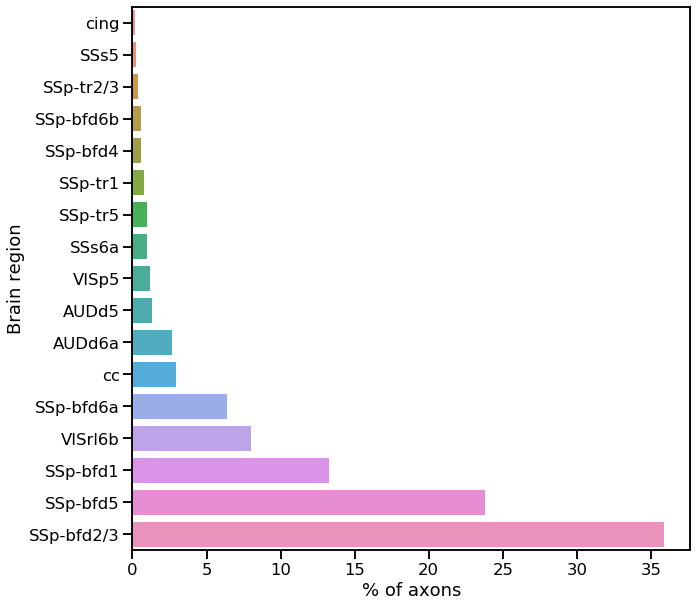

In [312]:
fig, ax = plt.subplots(figsize=[10,10])
my_plot=sns.barplot(y="acronym", x=percent, data=our_regionWcounts)
ax.set(xlabel='% of axons', ylabel='Brain region')
sns.set_context("talk")
sns.set_palette("pastel")
fig.savefig(outdir+"/RegionPlot.svg")

In [145]:
# Now project downsampled points into tiff to see if they make sense
svolume=np.zeros(atlas.GetSize())
#columns, rows, planes

zplanes=[]
for i in all_points:
    zplanes.append( i[2])
zplanes=np.unique(zplanes)
zplanes

array([ 68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182])

In [217]:
temp=np.zeros(atlas.GetSize()[0:2])
thepoints=np.asarray(all_points)

for i in zplanes:
    index= thepoints[:,2]==i
    uindex,counts=np.unique(thepoints[index],return_counts=True, axis=0)
    for j, lines in enumerate(uindex):
        coord1,coord2=lines[0:2]
        temp[coord1][coord2]= counts[j]
    svolume[:,:,i]=temp #write this in 
    temp=np.zeros(atlas.GetSize()[0:2]) #reset the empty plane after each z

In [223]:
for j, lines in enumerate(uindex):
    coord1,coord2=lines[0:2]
    temp[coord1][coord2]= counts[j]

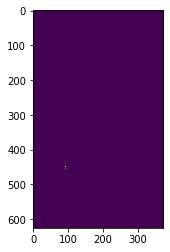

In [225]:
plt.imshow(svolume[:,:,69])

In [233]:
coronal_planetmp= np.swapaxes(np.int16(svolume),0,2)
#for some reason, if just save stuff as tiff, it will save x planes of yz view
#here we shift the 3rd dimension with the first dimension to obtain xy view

io.imsave(outdir+'/DS_points.tif',coronal_planetmp)